In [2]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

sampling_rate=2048 
duration=50 
time_of_event = 2483.97
duration = 6
post_trigger_duration = 2

start_time=time_of_event + post_trigger_duration - duration

interferometers = bilby.gw.detector.InterferometerList([])
for ifo_name in ['H1','L1']:
    ifo=bilby.gw.detector.get_empty_interferometer(ifo_name)
    ifo.set_strain_data_from_frame_file('challenge3.gwf',sampling_rate, duration, start_time=start_time ,channel=ifo_name+':CHALLENGE3')
    interferometers.append(ifo)

15:24 bilby INFO    : Reading data from frame file challenge3.gwf
15:24 bilby INFO    : Successfully loaded H1:CHALLENGE3.
15:24 bilby INFO    : Reading data from frame file challenge3.gwf
15:24 bilby INFO    : Successfully loaded L1:CHALLENGE3.


In [3]:
H1_analysis_data = TimeSeries.read('challenge3.gwf', 'H1:CHALLENGE3')
psd_duration = duration*32
psd_start_time = start_time - psd_duration
H1_analysis_data = H1_analysis_data.crop(start_time, (start_time+psd_duration))


L1_analysis_data = TimeSeries.read('challenge3.gwf', 'L1:CHALLENGE3')
L1_analysis_data = L1_analysis_data.crop(start_time, (start_time+psd_duration))

In [4]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

df = interferometers[0].strain_data.to_pycbc_frequencyseries().delta_f
H1_psd = TimeSeries.psd(H1_analysis_data, 4)
L1_psd = TimeSeries.psd(L1_analysis_data, 4)

H1_psd = interpolate(H1_psd.to_pycbc(), df)
L1_psd = interpolate(L1_psd.to_pycbc(), df)
H1_psd.resize(len(interferometers[0].strain_data.frequency_array))
L1_psd.resize(len(interferometers[1].strain_data.frequency_array))

libkmod: ERROR ../libkmod/libkmod-module.c:1668 kmod_module_new_from_loaded: could not open /proc/modules: No such file or directory
Error: could not get list of modules: No such file or directory
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
15:25 bilby INFO    : Generating frequency domain strain from given time domain strain.
15:25 bilby INFO    : Applying a tukey window with alpha=0.06666666666666667, roll off=0.2


In [5]:
interferometers[0].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.sample_frequencies, psd_array=np.array(H1_psd))
interferometers[1].power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=L1_psd.sample_frequencies, psd_array=np.array(L1_psd))

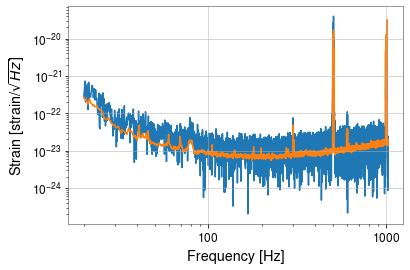

15:25 bilby INFO    : Generating frequency domain strain from given time domain strain.
15:25 bilby INFO    : Applying a tukey window with alpha=0.06666666666666667, roll off=0.2


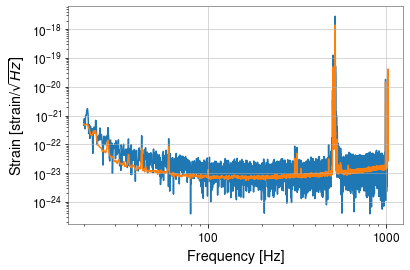

In [6]:
for ifo in interferometers:
    

    fig, ax = plt.subplots()
    idxs = ifo.strain_data.frequency_mask  
    ax.loglog(ifo.strain_data.frequency_array[idxs],
              np.abs(ifo.strain_data.frequency_domain_strain[idxs]))
    ax.loglog(ifo.power_spectral_density.frequency_array[idxs],
              ifo.power_spectral_density.asd_array[idxs])
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
    plt.show()

In [ ]:
#for ifo in interferometers:
    

    #fig, ax = plt.subplots()
    
    #ax.loglog(ifo.strain_data.to_pycbc_timeseries().sample_times, ifo.strain_data.to_pycbc_timeseries())
    #H1_analysis_data.plot(yscale = 'log', ylim = (10**(-22), 10**(-18)))

    #ax.set_xlabel("Time[s]")
    #ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
   # plt.show()

In [13]:
prior = bilby.gw.prior.BBHPriorDict()
prior['chirp_mass'] = bilby.core.prior.Uniform(name='chirp_mass', minimum=10,maximum=50)
prior['mass_ratio'] = 1
prior['phase'] = bilby.core.prior.Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = bilby.core.prior.Uniform(name="geocent_time", minimum=time_of_event-1, maximum=time_of_event+1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066

15:27 bilby INFO    : No prior given, using default BBH priors in /home/aravbj/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [ ]:
#prior = bilby.gw.prior.BBHPriorDict(filename="aligned_spins_bbh.prior")
#prior['a_1'] = 0
#prior['a_2'] =  0.0
#prior['tilt_1'] =  0.0
#prior['tilt_2'] =  0.0
#prior['phi_12'] =  0.0
#prior['phi_jl'] =  0.0
#prior['dec'] =  -1.2232
#prior['ra'] =  2.19432
#prior['theta_jn'] =  1.89694
#prior['psi'] =  0.532268
#prior['mass_ratio'] = 1
#prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)

In [14]:



waveform_arguments = dict(
    waveform_approximant='SEOBNRv4_opt', reference_frequency=50., catch_waveform_errors=True)


waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)


likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=False)


15:27 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [15]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short',
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    sample="unif", nlive=50, dlogz=3)

15:27 bilby INFO    : Running for label 'label', output will be saved to 'short'
15:27 bilby INFO    : Using lal version 7.1.7
15:27 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
15:27 bilby INFO    : Using lalsimulation version 3.1.2
15:27 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
15:27 bilby INFO    : Search parameters:
15:27 bilby INFO    :   chirp_mass = Uniform(minimum=10, maximum=50, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
15:27 bilby INFO    :   time_jitter = Uniform(minimum=-0.00048828125, maximum=0.00048828125, name='time_jitter', latex_label='$t_j$', unit=None, boundary='periodic')
15:27 bilby 

0it [00:00, ?it/s]

15:27 bilby INFO    : Checkpoint every check_point_delta_t = 600s
15:27 bilby WARNING : Using cached result
/home/aravbj/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/bilby/core/result.py:1453: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if "npool" in inspect.getargspec(conversion_function).args:
15:27 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/4687 [00:00<?, ?it/s]

TypeError: can't convert complex to float

In [ ]:
result_short.posterior